<a href="https://colab.research.google.com/github/dhasaf/Classification/blob/main/FlightPricePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Flight price prediction**
### Our goal is to build supervised Natural Language Processing (NLP) machine learning models to predict the price of a flight.

### **Import Libaries**

In [2]:
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
import os
import tarfile
import urllib

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score


### **Load the data**

In [3]:
flight = pd.read_csv("Flight_price.csv")
flight.head()

,number,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,lead_reservation,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


Take a 100,000 sample

In [4]:
flight = flight.sample(n=5000, random_state=42)

### **View data**

In [5]:
flight.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 27131 to 15601
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   number            50000 non-null  int64  
 1   airline           50000 non-null  object 
 2   flight            50000 non-null  object 
 3   source_city       50000 non-null  object 
 4   departure_time    50000 non-null  object 
 5   stops             50000 non-null  object 
 6   arrival_time      50000 non-null  object 
 7   destination_city  50000 non-null  object 
 8   class             50000 non-null  object 
 9   duration          50000 non-null  float64
 10  lead_reservation  50000 non-null  int64  
 11  price             50000 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 5.0+ MB


In [6]:
flight.describe()

,number,duration,lead_reservation,price
count,50000.00000,50000.000000,50000.000000,50000.000000
mean,150015.80588,12.245605,26.012500,20827.466020
std,86528.55104,7.179290,13.531321,22658.672268
min,0.00000,0.830000,1.000000,1105.000000
25%,75307.50000,6.830000,15.000000,4784.000000
50%,150187.50000,11.250000,26.000000,7424.000000
75%,224778.25000,16.170000,38.000000,42521.000000
max,300152.00000,47.750000,49.000000,114705.000000


In [7]:
flight.shape

(50000, 12)

**Check number of null values**

In [8]:
flight.isnull().sum()

number              0
airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
lead_reservation    0
price               0
dtype: int64

Check duplicates 

In [9]:
flight.duplicated().sum()

0

number of unique data for each feature

In [10]:
flight.nunique()

number              50000
airline                 6
flight               1438
source_city             6
departure_time          6
stops                   3
arrival_time            6
destination_city        6
class                   2
duration              432
lead_reservation       49
price                6648
dtype: int64

As we understand from the result above, the "number" column is an index since its unique values are just like the size of our dataset, which is 300153.
So, it will be dropped from our dataset.

In [11]:
flight.drop(["number"], axis=1, inplace=True)

In [12]:
flight.drop(["flight"], axis=1, inplace=True)

In [13]:
flight.shape

(50000, 10)

convert price from int to float

In [14]:
flight['price'] = flight['price'].astype(float)

**Detect and Remove outliers** 

In [15]:
flight.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 27131 to 15601
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   airline           50000 non-null  object 
 1   source_city       50000 non-null  object 
 2   departure_time    50000 non-null  object 
 3   stops             50000 non-null  object 
 4   arrival_time      50000 non-null  object 
 5   destination_city  50000 non-null  object 
 6   class             50000 non-null  object 
 7   duration          50000 non-null  float64
 8   lead_reservation  50000 non-null  int64  
 9   price             50000 non-null  float64
dtypes: float64(2), int64(1), object(7)
memory usage: 4.2+ MB


<Axes: xlabel='lead_reservation'>

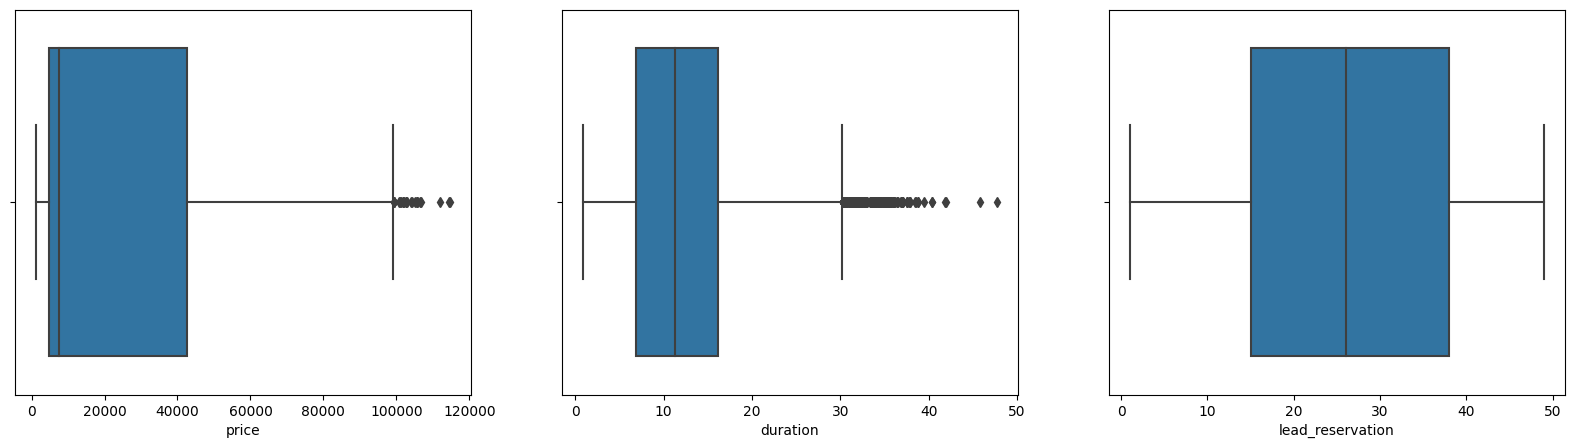

In [16]:
# Create a figure and axes for box plots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20,5))

# Draw box plots for each feature
sns.boxplot(x=flight['price'], ax=axs[0])
sns.boxplot(x=flight['duration'], ax=axs[1])
sns.boxplot(x=flight['lead_reservation'], ax=axs[2])

In [17]:
Q1 = flight.quantile(0.25)
Q3 = flight.quantile(0.75)
IQR = Q3 - Q1
flight = flight[~((flight < (Q1 - 1.5 * IQR)) |(flight > (Q3 + 1.5 * IQR))).any(axis=1)]

<ipython-input-17-63ea7a9fe649>:1: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q1 = flight.quantile(0.25)
<ipython-input-17-63ea7a9fe649>:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q3 = flight.quantile(0.75)
<ipython-input-17-63ea7a9fe649>:4: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  flight = flight[~((flight < (Q1 - 1.5 * IQR)) |(flight > (Q3 + 1.5 * IQR))).any(axis=1)]


<Axes: xlabel='lead_reservation'>

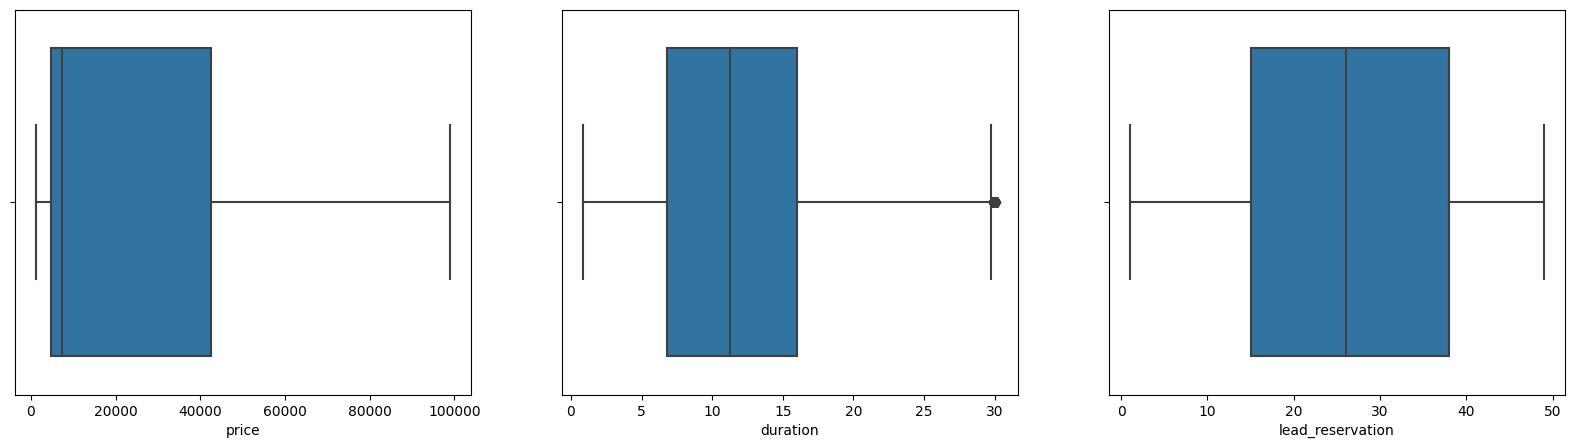

In [18]:
# Create a figure and axes for box plots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20,5))

# Draw box plots for each feature
sns.boxplot(x=flight['price'], ax=axs[0])
sns.boxplot(x=flight['duration'], ax=axs[1])
sns.boxplot(x=flight['lead_reservation'], ax=axs[2])

In [19]:
flight.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49623 entries, 27131 to 15601
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   airline           49623 non-null  object 
 1   source_city       49623 non-null  object 
 2   departure_time    49623 non-null  object 
 3   stops             49623 non-null  object 
 4   arrival_time      49623 non-null  object 
 5   destination_city  49623 non-null  object 
 6   class             49623 non-null  object 
 7   duration          49623 non-null  float64
 8   lead_reservation  49623 non-null  int64  
 9   price             49623 non-null  float64
dtypes: float64(2), int64(1), object(7)
memory usage: 4.2+ MB


In [20]:
flight_dumm = pd.get_dummies(flight)
flight= pd.concat([flight_dumm], axis=1)
print(flight_dumm)

        duration  lead_reservation    price  airline_AirAsia  \
27131      19.75                40   7366.0                0   
266857      9.83                42  64831.0                0   
141228     10.50                41   6195.0                0   
288329     14.50                14  60160.0                0   
97334       8.25                20   6578.0                0   
...          ...               ...      ...              ...   
50691      14.25                39   5828.0                0   
22037      16.00                13   5954.0                0   
233495     16.33                41  85744.0                0   
107611     14.42                35   7978.0                0   
15601       5.58                29   3671.0                0   

        airline_Air_India  airline_GO_FIRST  airline_Indigo  airline_SpiceJet  \
27131                   1                 0               0                 0   
266857                  0                 0               0          

In [21]:
flight.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49623 entries, 27131 to 15601
Data columns (total 38 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   duration                      49623 non-null  float64
 1   lead_reservation              49623 non-null  int64  
 2   price                         49623 non-null  float64
 3   airline_AirAsia               49623 non-null  uint8  
 4   airline_Air_India             49623 non-null  uint8  
 5   airline_GO_FIRST              49623 non-null  uint8  
 6   airline_Indigo                49623 non-null  uint8  
 7   airline_SpiceJet              49623 non-null  uint8  
 8   airline_Vistara               49623 non-null  uint8  
 9   source_city_Bangalore         49623 non-null  uint8  
 10  source_city_Chennai           49623 non-null  uint8  
 11  source_city_Delhi             49623 non-null  uint8  
 12  source_city_Hyderabad         49623 non-null  uint8  
 1

In [22]:
flight.head()

,duration,lead_reservation,price,airline_AirAsia,airline_Air_India,airline_GO_FIRST,airline_Indigo,airline_SpiceJet,airline_Vistara,source_city_Bangalore,...,arrival_time_Morning,arrival_time_Night,destination_city_Bangalore,destination_city_Chennai,destination_city_Delhi,destination_city_Hyderabad,destination_city_Kolkata,destination_city_Mumbai,class_Business,class_Economy
27131,19.75,40,7366.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
266857,9.83,42,64831.0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,1,1,0
141228,10.50,41,6195.0,0,0,0,0,0,1,0,...,0,1,1,0,0,0,0,0,0,1
288329,14.50,14,60160.0,0,0,0,0,0,1,0,...,1,0,0,0,1,0,0,0,1,0
97334,8.25,20,6578.0,0,1,0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,1


**Draw histogram to view the numeric values distribution**

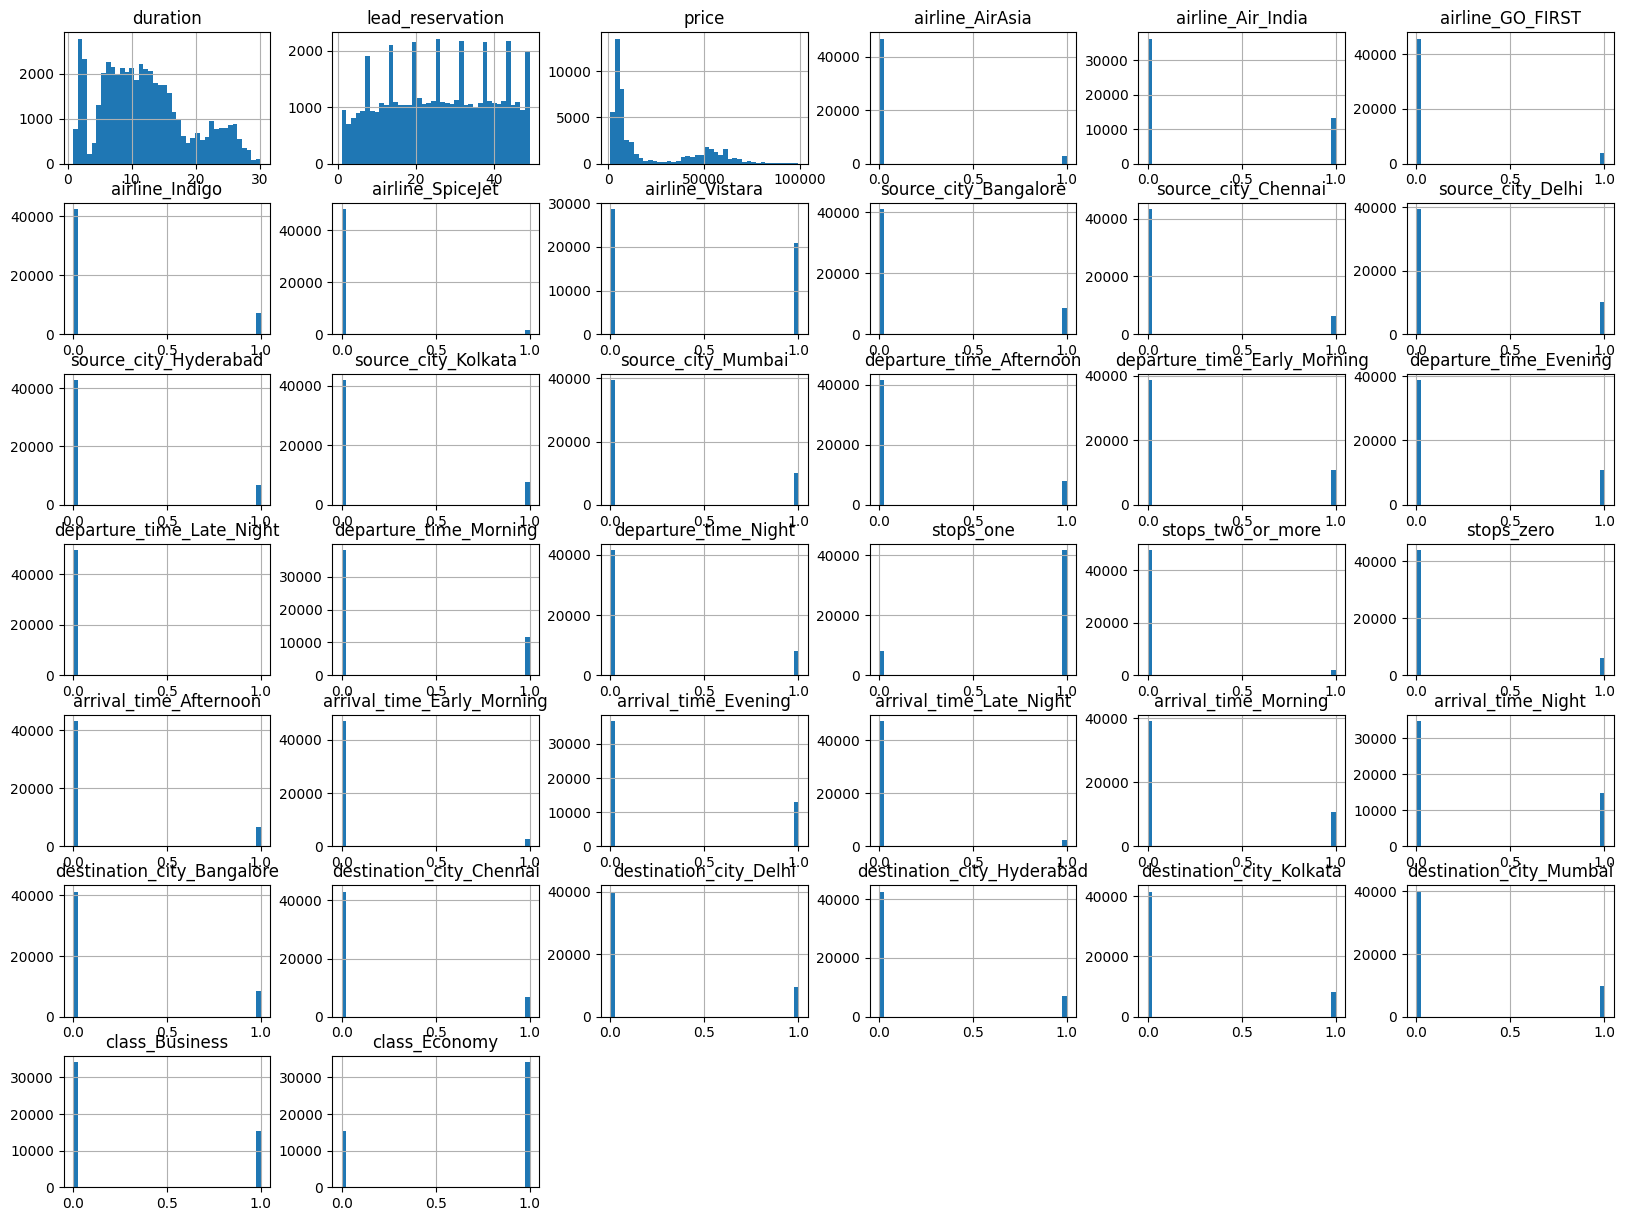

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
flight.hist(bins=40, figsize=(20,15))
plt.show()

### **Get the size of taining set and test set**

In [24]:
#using Scikit-Learn train_test_split()
train_set, test_set = train_test_split(flight, test_size=0.2, random_state=42)
print("size of training data",len(train_set))
print("size of testing data",len(test_set))

size of training data 39698
size of testing data 9925


In [25]:
flightX = train_set.drop("price", axis =1)
flightY = train_set["price"].copy()
##X_train, X_test, y_train, y_test = train_test_split(flightX, flightY, test_size=0.2, random_state=42)

### **Linear Regression**




In [26]:
from sklearn.linear_model import LinearRegression
lin_reg= LinearRegression()
lin_reg.fit(flightX, flightY)
lin_reg_pred= lin_reg.predict(flightX)
lin_mse= mean_squared_error(flightY, lin_reg_pred)
lin_rmse= np.sqrt(lin_mse)
print("Linear Regression mean squared error: ", lin_rmse)
print("Accuracy: ",lin_reg.score(flightX, flightY))

Linear Regression mean squared error:  6664.819377188472
Accuracy:  0.9132846338270899


In [27]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard Deviation:", scores.std())

In [28]:
lin_scores = cross_val_score(lin_reg,flightX,flightY, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [6858.04344077 6862.98066142 6607.34911805 6604.92295284 6762.70069217
 6513.16116689 6461.75972204 6780.88712785 6595.47818134 6630.42767376]
Mean: 6667.77107371249
Standard Deviation: 132.92239168134606


### **Random Forest**

In [29]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(flightX,flightY)
forest_price_predicitons= forest_reg.predict(flightX)
regr_score = forest_reg.score(flightX, flightY)
forest_mse= mean_squared_error(flightY, forest_price_predicitons)
forest_rmse= np.sqrt(forest_mse)
forest_rmse

1203.4045091668902

In [30]:
print("Accuracy: ", regr_score)

Accuracy:  0.9971728909358969


In [31]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard Deviation:", scores.std())

In [32]:
from sklearn.model_selection import cross_val_score
forest_scores = cross_val_score(forest_reg,flightX,flightY, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores= np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [3286.56285776 3220.49477229 3251.05891261 3260.33068466 3343.06506555
 3235.25701373 3033.31800618 3349.59777584 3182.1686601  3039.26551075]
Mean: 3220.1119259483426
Standard Deviation: 103.99118076266551


### **Decision Tree Regressor**

In [33]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(flightX, flightY) #train the model
price_predictions = tree_reg.predict(flightX) #predict
tree_score = tree_reg.score(flightX, flightY)
tree_mse = mean_squared_error (flightY, price_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

260.40323604911987

In [34]:
print("Accuracy: ", tree_score)

Accuracy:  0.9998676231483473


In [35]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, flightX, flightY, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [36]:
display_scores(tree_rmse_scores)

Scores: [4014.61261391 4138.68914374 4364.84731895 4092.52601721 4332.14831276
 4294.70413526 4107.26805084 4249.41048104 4222.41716459 4109.62954734]
Mean: 4192.625278563086
Standard Deviation: 110.65755383506466


### **Support Vector Machine regressor**

In [37]:
from sklearn.svm import SVR
SVR_reg= SVR(kernel='linear', C=1)
SVR_reg.fit(flightX, flightY)
SVR_housing_predictions= SVR_reg.predict(flightX)
SVR_score = SVR_reg.score(flightX, flightY)
SVR_mse=mean_squared_error(flightY, SVR_housing_predictions)
SVR_rmse= np.sqrt(SVR_mse)
SVR_rmse 

13769.314431119852

In [38]:
print("Accuracy: ", SVR_score)

Accuracy:  0.6298788277821099


In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(SVR_reg, flightX, flightY, scoring="neg_mean_squared_error", cv=10)
SVR_rmse_scores = np.sqrt(-scores)

In [ ]:
display_scores(SVR_rmse_scores)

In [1]:
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, max_depth=3)
model.fit(flightX, flightY)
GB_price_pred = model.predict(flightX)
GB_score = model.score(flightX, flightY)
GB_mse=mean_squared_error(flightY, GB_price_pred)
GB_rmse= np.sqrt(GB_mse)
GB_rmse 

NameError: ignored

In [ ]:
print("Accuracy: ", SVR_score)